In [0]:
%tensorflow_version 2.x

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

TensorFlow 2.x selected.


In [0]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-03-25 12:35:04--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.48MB/s    in 0.6s    

2020-03-25 12:35:05 (1.48 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [0]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [0]:
movies=pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
ratings=pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [0]:
ratings = ratings.merge(movies, on='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [0]:
user_enc=LabelEncoder()
ratings['user_seq']=user_enc.fit_transform(ratings['userId'].values)

item_enc=LabelEncoder()
ratings['movie_seq']=item_enc.fit_transform(ratings['movieId'].values)
ratings.head()

,userId,movieId,rating,title,user_seq,movie_seq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


In [0]:
train_unused,test=train_test_split(ratings,test_size=.20,random_state=0)
train=ratings
numUsers = len(train.user_seq.unique())
numMovies = len(train.movie_seq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(100836, 20168)


In [0]:
numFeatures=50
dropout=0.0
user_input=Input(shape=(1,))
user_emb=Embedding(numUsers,numFeatures)(user_input)
flat_user=  Flatten()(user_emb)
user_dropout=Dropout(dropout)(flat_user)

movie_input=Input(shape=(1,))
movie_emb=Embedding(numMovies,numFeatures)(movie_input)
flat_movie=  Flatten()(movie_emb)
movie_dropout=Dropout(dropout)(flat_movie)

dotProduct=Dot(axes=1)([user_dropout,movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum=Add()([dotProduct,user_bias,movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model=Model([user_input,movie_input],output)
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
______________________________________________________________________________________________

Train on 100836 samples, validate on 20168 samples
Epoch 1/10
100836/100836 [==============================] - 34s 337us/sample - loss: 6.1729 - val_loss: 1.4464
Epoch 2/10
100836/100836 [==============================] - 25s 247us/sample - loss: 1.1403 - val_loss: 0.7993
Epoch 3/10
100836/100836 [==============================] - 26s 256us/sample - loss: 0.8095 - val_loss: 0.6465
Epoch 4/10
100836/100836 [==============================] - 26s 256us/sample - loss: 0.6755 - val_loss: 0.5397
Epoch 5/10
100836/100836 [==============================] - 25s 253us/sample - loss: 0.5729 - val_loss: 0.4590
Epoch 6/10
100836/100836 [==============================] - 25s 252us/sample - loss: 0.4853 - val_loss: 0.3855
Epoch 7/10
100836/100836 [==============================] - 25s 252us/sample - loss: 0.4051 - val_loss: 0.3163
Epoch 8/10
100836/100836 [==============================] - 25s 247us/sample - loss: 0.3338 - val_loss: 0.2529
Epoch 9/10
100836/100836 [==============================] - 2

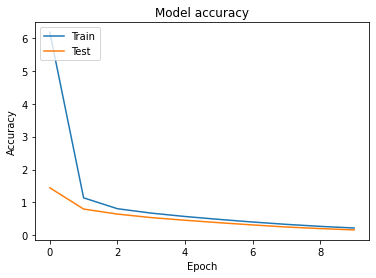

In [0]:
model.compile(loss='mean_squared_error',optimizer=Adam())
history=model.fit([train.user_seq,train.movie_seq],train.rating,batch_size=32,epochs=10,verbose=1,validation_data=([test.user_seq,test.movie_seq],test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
userNumber=0
uniqueMovies=ratings.drop_duplicates(subset=['movie_seq'])
movie_vector=uniqueMovies.movie_seq.values
user_vector=np.ones((len(uniqueMovies),))*userNumber
predictions=model.predict([user_vector,movie_vector])
pSeries=pd.Series(a[0] for a in predictions)
predictedDF=uniqueMovies.copy()
predictedDF['Predictions'] = pSeries

predictedDF.sort_values(by='Predictions', ascending=False).head(10)

,userId,movieId,rating,title,user_seq,movie_seq,Predictions
5770,1,1025,5.0,"Sword in the Stone, The (1963)",0,783,6.028817
4121,1,592,4.0,Batman (1989),0,509,5.813938
6347,1,1090,4.0,Platoon (1986),0,828,5.710107
6127,1,1080,5.0,Monty Python's Life of Brian (1979),0,819,5.641839
2755,1,362,5.0,"Jungle Book, The (1994)",0,320,5.429348
4992,1,661,5.0,James and the Giant Peach (1996),0,551,5.400470
5751,1,1023,5.0,Winnie the Pooh and the Blustery Day (1968),0,781,5.342366
1135,1,157,5.0,Canadian Bacon (1995),0,130,5.333259
4830,1,648,3.0,Mission: Impossible (1996),0,546,5.274713
6988,1,1197,5.0,"Princess Bride, The (1987)",0,898,5.130636


In [0]:
oneUser=predictedDF[predictedDF.user_seq==userNumber].copy()
oneUser['error']=(oneUser.rating-oneUser.Predictions)**2
oneUser.sort_values(by='error' ,ascending=False).head(5)

,userId,movieId,rating,title,user_seq,movie_seq,Predictions,error
4649,1,608,5.0,Fargo (1996),0,520,0.862767,17.116696
6216,1,1089,5.0,Reservoir Dogs (1992),0,827,1.354774,13.287675
7130,1,1198,5.0,Raiders of the Lost Ark (Indiana Jones and the...,0,899,1.449463,12.606310
6641,1,1136,5.0,Monty Python and the Holy Grail (1975),0,862,1.532019,12.026895
8450,1,1256,5.0,Duck Soup (1933),0,954,1.869553,9.799696


In [0]:
ratings[ratings.movie_seq == 520].sort_values(by='rating', ascending=True)

,userId,movieId,rating,title,user_seq,movie_seq
4827,607,608,2.0,Fargo (1996),606,520
4672,78,608,2.0,Fargo (1996),77,520
4810,546,608,2.0,Fargo (1996),545,520
4669,71,608,2.0,Fargo (1996),70,520
4812,554,608,2.0,Fargo (1996),553,520
...,...,...,...,...,...,...
4725,251,608,5.0,Fargo (1996),250,520
4718,221,608,5.0,Fargo (1996),220,520
4717,220,608,5.0,Fargo (1996),219,520
4754,324,608,5.0,Fargo (1996),323,520
